# Деревья решений, kNN

Мы рассмотрели с вами класс линейных моделей, немножко ядерные методы (svm). Сегодня посмотрим на другой класс моделей, который является обобщением довольно простой идеи: "скажи мне кто твои друзья и я скажу кто ты" и "поделить и обобщить" 

Нам понадобится важное понятие энтропии, с которым мы уже сталкивались (в логистической регрессии, функции потерь).


## Энтропия

(порисуем на доске https://cocreate.csail.mit.edu/r/xkyRGeYCda2vYvg2P что это такое) 
$$H = -\sum_i p_i \log p_i$$
Это магическое слово, которое все так часто употребляют и совсем не все понимают про что оно. Энтропия нам говорит (намеками) о том, насколько сложно нам судить о состоянии системы, сколько вопросов надо задать, чтобы что-то узнать. Что? Например, представим себе кубик, заполненный частичками цветной пыли, покроем кубик мысленной сеточкой из маленьких кубиков, и будем выяснять где живет самая красивая, розовая. Если бы все пылинки сидели в одном месте в уголке, то достаточно было бы одного вопроса, чтобы ее найти. Но они же разбегаются, и скорее всего придется пробежаться по всем маленьким кубикам, пока ее найдешь. Так вот, это про то, почему частицы разбегаются так как они разбегаются, провода путаются так как обычно путаются, а люди живут так как живут. Ведь вариантов все перепутать и разбросать гораздо больше, чем разложить по местам.  Наделать ошибок можно гораздо проще и разнообразней, чем не наделать. А все потому, что работает принцип максимума энтропии. А любим мы все полежать в кровати, совсем не из-за лени, а потому что работает принцип минимума потенциальной энергии, тот же который делает капельку шариком:)


### Задание
Представьте, что у вас есть 5 корзин и 10 маркированных камней. Вам предложено несколько возможных распределений камней по корзинам. Посчитайте для каждого случая число всех возможных комбинаций  для реализации каждого распределения. Постройте график зависимости энтропии и логарифма числа возможных комбинаций для каждого случая  


In [3]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
def entropy(x):
    x  = x/np.sum(x)
    return -np.sum([i*np.log(i) if i>0 else 0 for i in x ])

d = {'A':[0, 0, 10, 0, 0], 
     'B':[0, 1, 8, 1, 0], 
     'C':[0, 2, 6, 2, 0], 
     'D':[1, 2, 4, 2, 1], 
     'E':[2, 2, 2, 2, 2]}

и какой вывод? что заметили?
(дорисуем на доске)

## Деревья решений

Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности, порой и очень далеких от машинного обучения. Деревом решений можно назвать наглядную инструкцию, что делать в какой ситуации.

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.
<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>
В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000. Как мы увидим дальше, многие другие, хоть и более точные, модели не обладают этим свойством и могут рассматриваться скорее как "черный ящик", в который загрузили данные и получили ответ. В связи с этой "понятностью" деревьев решений и их сходством с моделью принятия решений человеком (можно легко объяснять боссу свою модель), деревья решений получили огромную популярность, а один из представителей этой группы методов классификации, С4.5, рассматривается первым в списке 10 лучших алгоритмов интеллектуального анализа данных ("Top 10 algorithms in data mining", Knowledge and Information Systems, 2008. [PDF](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf)).
### Пример (взято с mlcourse.ru)
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье <a href="https://habrahabr.ru/post/171759/">"Энтропия и деревья принятия решений"</a>. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

### Критерий Джини
Мы разобрались, в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего-лишь эвристика, существуют и другие:

 - Неопределенность Джини (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. 

Именно этот параметр используется в деревьях по умолчанию, на практике неопределенность Джини и прирост информации работают почти одинаково. График энтропии очень близок к графику удвоенной неопределенности Джини

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:




In [23]:
data = pd.DataFrame({'Age':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Salary': [25,80,22,36,37,59,74,70,33,102,88], 
             'Default': [1,0,1,0,1,0,0,1,1,0,1]})
data

,Age,Salary,Default
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


In [24]:
data.sort_values(by = ['Salary','Age'])

,Age,Salary,Default
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


Обучаем дерево с энтропией в качестве критерия 

Качество на трейне 0.82


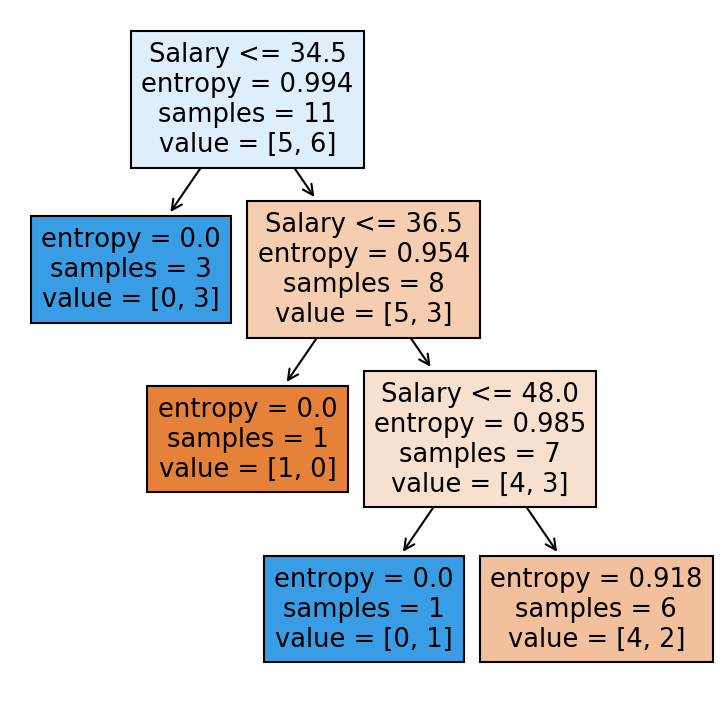

In [34]:
print('Обучаем дерево с энтропией в качестве критерия \n')
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(data.Salary.values.reshape(-1,1), data.Default.values.reshape(-1,1))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=150)
tree.plot_tree(clf_tree, feature_names=['Salary'],  filled=True);
print(f'Качество на трейне {clf_tree.score(data.Salary.values.reshape(-1,1), data.Default.values.reshape(-1,1)):.2f}')

Обучаем дерево с энтропией в качестве критерия 

Качество на трейне 0.82


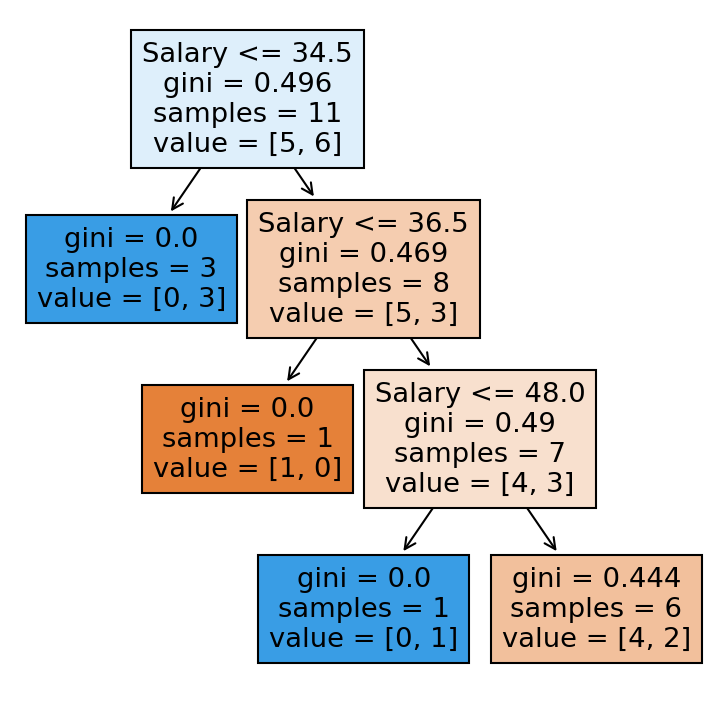

In [35]:
print('Обучаем дерево с энтропией в качестве критерия \n')
clf_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(data.Salary.values.reshape(-1,1), data.Default.values.reshape(-1,1))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=150)
tree.plot_tree(clf_tree, feature_names=['Salary'],  filled=True);
print(f'Качество на трейне {clf_tree.score(data.Salary.values.reshape(-1,1), data.Default.values.reshape(-1,1)):.2f}')

Обучаем дерево с энтропией в качестве критерия 

Качество на трейне 0.91


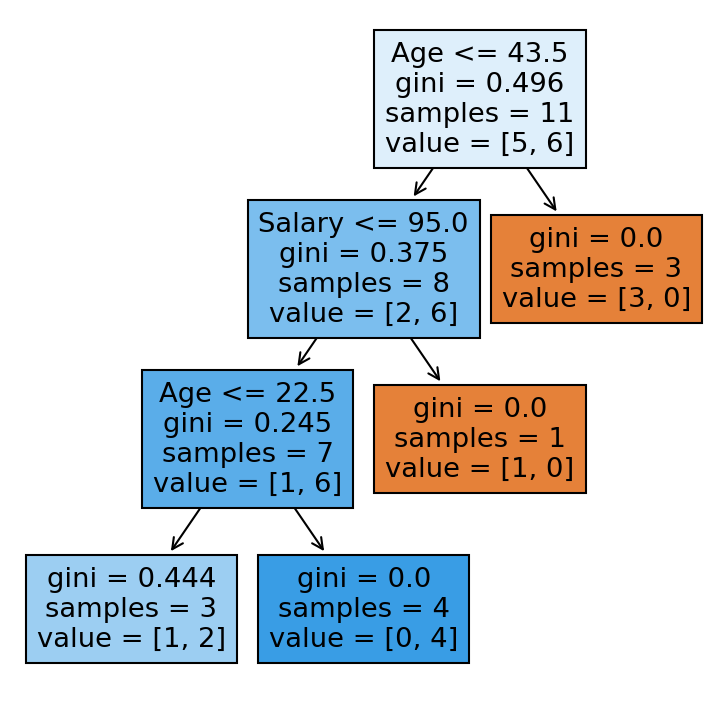

In [43]:
print('Обучаем дерево с энтропией в качестве критерия \n')
clf_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(data[['Salary','Age']], data.Default.values.reshape(-1,1))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=150)
tree.plot_tree(clf_tree, feature_names=['Salary','Age'],  filled=True);
score = clf_tree.score(data[['Salary','Age']], data.Default.values.reshape(-1,1))
print(f'Качество на трейне {score:.2f}')

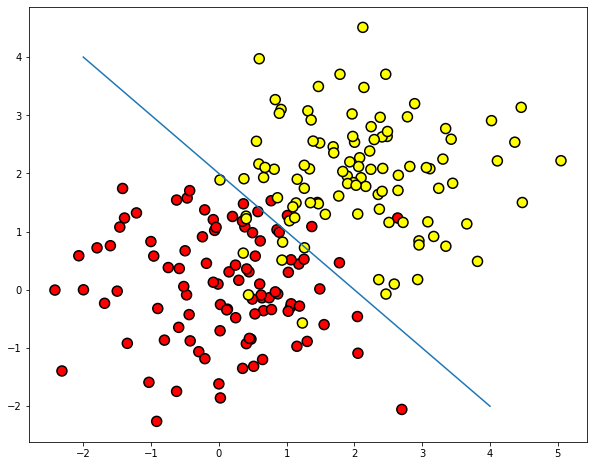

In [5]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

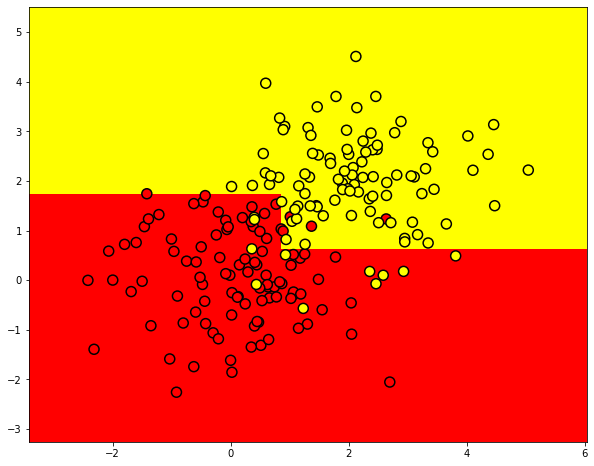

In [17]:

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

Решите это задание с уже известными вам Logistic Regression и SVM
(в группах)

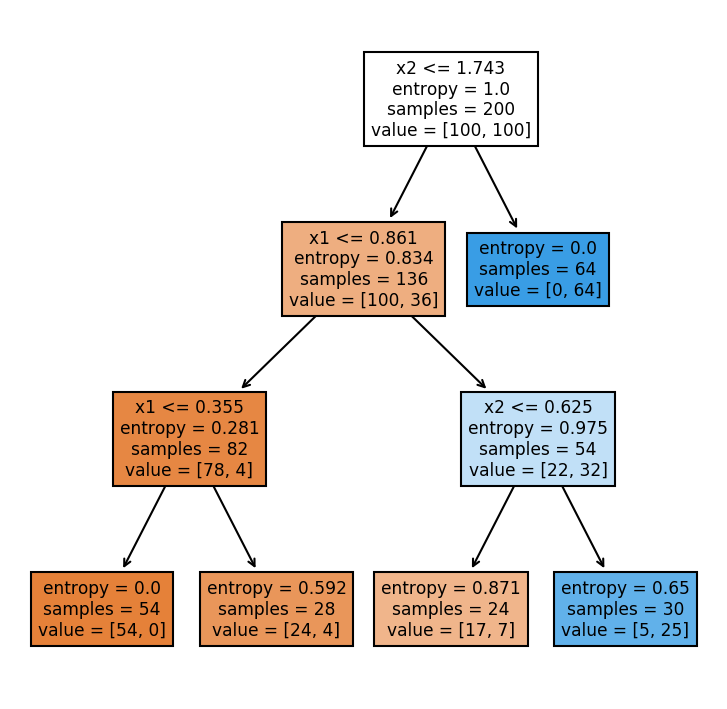

In [18]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=150)
tree.plot_tree(clf_tree, feature_names=['x1', 'x2'],  filled=True);

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*, о которой чуть ниже). Подробнее можно почитать в  материалах [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова.

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.

## Дерево решений в задаче регрессии
 
 При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества: 
 
 - Дисперсия вокруг среднего: $$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$
 где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.
#### Пример
Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом. 

In [44]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

Text(0.5, 1.0, 'Decision tree regressor, MSE = 0.02')

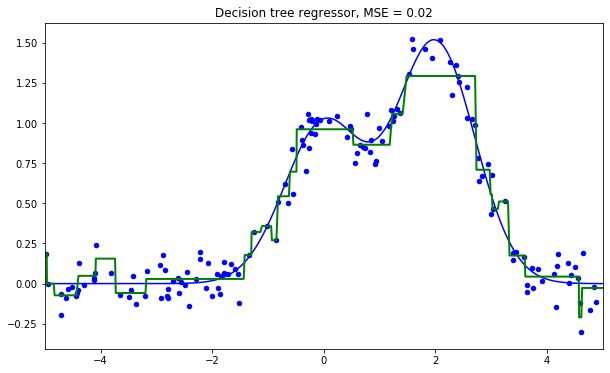

In [46]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))

## Случайный лес

Изолированное дерево решений само по себе алгоритм, склонный очень сильно переобучаться, особенно если разрешить дереву расти "глубоко". Можем всегда добиться того, что в одном листе будет по одному предмету и мы достигнем идеального качества, при этом на новые данные обобщаться алгоритм будет очень плохо.
### Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных. 
- $\large N $ — количество присяжных
- $\large p $ — вероятность правильного решения присяжного
- $\large \mu $ — вероятность правильного решения всего жюри
- $\large m $ — минимальное большинство членов жюри, $ m = floor(N/2) + 1 $
- $\large C_N^i$ — число [сочетаний](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%87%D0%B5%D1%82%D0%B0%D0%BD%D0%B8%D0%B5) из $N$ по $i$
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
Если $\large p > 0 $, то $\large \mu > p $
Если $\large N \rightarrow \infty $, то $\large \mu \rightarrow 1 $
<img src="../../img/bull.png" align="right" width=15% height=15%>
Давайте рассмотрим ещё один пример ансамблей — "Мудрость толпы". Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян. 
Их собралось около 800 человек и они пытались угадать вес быка, который стоял перед ними. Его вес составлял 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.


### Бутстрэп


Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

Лео Брейман нашел применение бутстрэпу не только в статистике, но и в машинном обучении. Он вместе с Адель Катлер усовершенстовал алгоритм случайного леса, который был предложенный [Хо](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf), добавив к первоначальному варианту построение некоррелируемых деревьев на основе CART, в сочетании с методом случайных подпространств и бэггинга. 

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.
Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:
1. Пусть количество объектов для тренировки равно $\large N$, а количество признаков $\large D$.
2. Выберите $\large L$ как число отдельных моделей в ансамбле.
3. Для каждой отдельной модели $\large l$ выберите $\large dl (dl < D) $ как число признаков для $\large l$ . Обычно для всех моделей используется только одно значение $\large dl$.
4. Для каждой отдельной модели $\large l$ создайте обучающую выборку, выбрав $\large dl$-признаков из $\large D$ с заменой и обучите модель.

Теперь, чтобы применить модель ансамбля к новому объекту, объедините результаты отдельных $\large L$ моделей мажоритарным голосованием или путем комбинирования апостериорных вероятностей.


### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:
* Для каждого $\large n = 1, \dots, N$:
     * Сгенерировать выборку $\large X_n$ с помощью bootstrap.
     * Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
         
Итоговый классификатор $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $\large m = \sqrt{n}$, а в задачах регрессии — $\large m = \frac{n}{3}$, где $\large n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.

### Параметры


Метод случайного леса реализован в библиотеке машинного обучения [scikit-learn](http://scikit-learn.org/stable/) двумя классами RandomForestClassifier и RandomForestRegressor.

Полный список параметров случайного леса для задачи регрессии:
Таким образом, случайный лес — это композиция решающих деревьев, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

```class sklearn.ensemble.RandomForestRegressor(
    n_estimators — число деревьев в "лесу" (по дефолту – 10)
    criterion — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
)```

Для задачи классификации все почти то же самое, мы приведем только те параметры, которыми RandomForestClassifier отличается от RandomForestRegressor 

```class sklearn.ensemble.RandomForestClassifier(
    criterion — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
    class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
```

Text(0.5, 1.0, 'Random forest regressor, MSE = 0.01')

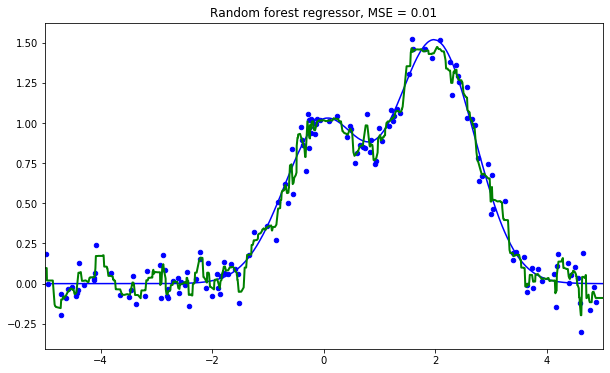

In [57]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
     
reg_rf = RandomForestRegressor(n_estimators=500)

reg_rf.fit(X_train, y_train)
reg_rf_pred = reg_rf.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_rf_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest regressor, MSE = %.2f" % (np.sum((y_test - reg_rf_pred) ** 2) / n_test))

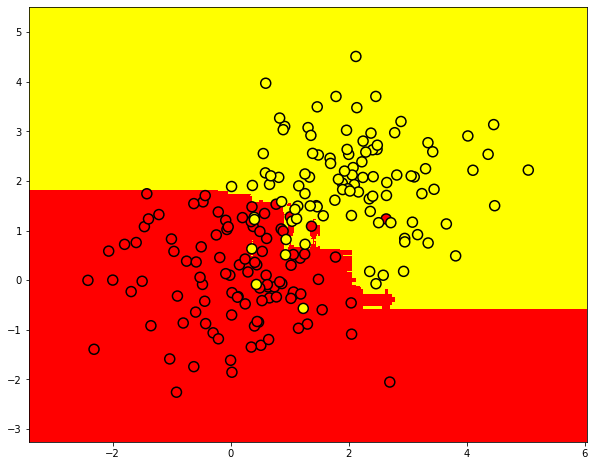

In [54]:
clf_rf = RandomForestClassifier(n_estimators=100)

# обучаем дерево
clf_rf.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотезой компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 


Например, если не знаешь, какой тип товара указать в объявлении для Bluetooth-гарнитуры, можешь найти 5 похожих гарнитур, и если 4 из них отнесены к категории "Аксессуары", и только один - к категории "Техника", то здравый смысл подскажет для своего объявления тоже указать категорию "Аксессуары".

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей
 
 Примечательное свойство такого подхода  – его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при  наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров. 
 
Стоит отметить, что метод ближайших соседей – хорошо изученный подход (в машинном обучении, эконометрике и статистике больше известно наверно только про линейную регрессию). Для метода ближайших соседей существует немало важных теорем, утверждающих, что на "бесконечных" выборках это оптимальный метод классификации. Авторы классической книги "The Elements of Statistical Learning" считают kNN теоретически идеальным алгоритмом, применимость которого просто ограничена вычислительными возможностями и проклятием размерностей. 

### Метод ближайших соседей в реальных задачах
- В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
- В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
- Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди *ближайших соседей* человека, которому хотим сделать рекомендацию;
- На практике для больших выборок часто пользуются *приближенными* методами поиска ближайших соседей. [Вот](https://www.youtube.com/watch?v=UUm4MOyVTnE) лекция Артема Бабенко про эффективные алгоритмы поиска ближайших соседей среди миллиардов объектов в пространствах высокой размерности (поиск по картинкам). Также известны открытые библиотеки, в которых реализованы такие алгоритмы, спасибо компании Spotify за ее библиотеку [Annoy](https://github.com/spotify/annoy).

Качество классификации методом ближайших соседей зависит от нескольких параметров:
 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100. 
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")
 
### Класс KNeighborsClassifier в Scikit-learn
Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
 - weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
 - algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
 - leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
 - metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие 

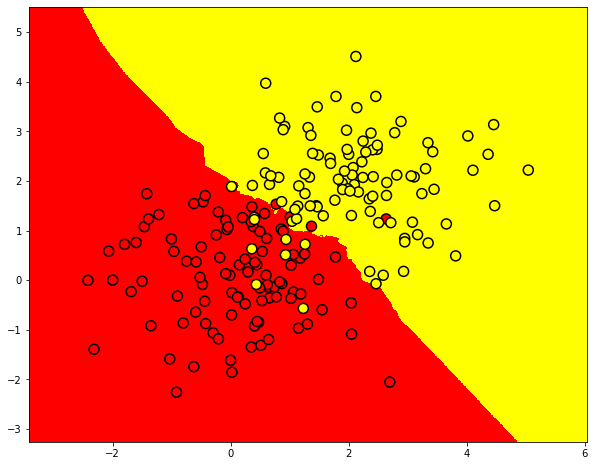

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

Text(0.5, 1.0, 'Knn regressor, MSE = 0.01')

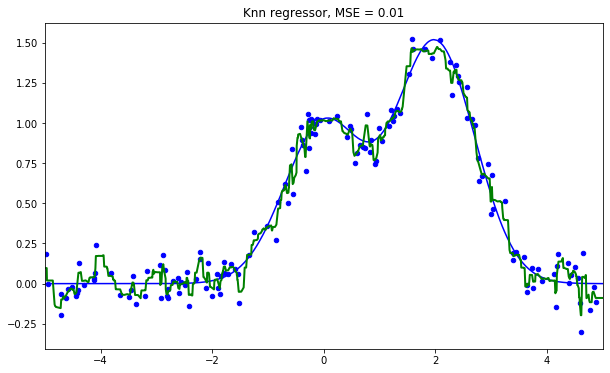

In [68]:
from sklearn.neighbors import KNeighborsRegressor
     
knn_reg = KNeighborsRegressor(n_neighbors=4)

knn_reg.fit(X_train, y_train)
knn_reg_pred = knn_reg.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_rf_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Knn regressor, MSE = %.2f" % (np.sum((y_test - knn_reg_pred) ** 2) / n_test))

## Плюсы и минусы деревьев решений

**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
 - Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
 - Быстрые процессы обучения и прогнозирования;
 - Малое число параметров модели;
 - Поддержка и числовых, и категориальных признаков.
 
**Минусы:**
 - У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
 - Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
 - Сложно поддерживаются пропуски в данных. Friedman оценил, что на поддержку пропусков в данных ушло около 50% кода CART (классический алгоритм построения деревьев классификации и регрессии – Classification And Regression Trees, в `sklearn` реализована улучшенная версия именно этого алгоритма);
 - Модель умеет только интерполировать, но не  экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.
 
 
### Плюсы и минусы метода ближайших соседей

Плюсы:
 - Простая реализация
 - Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же). Кстати, профессор ВМК МГУ и опытный участник соревнований по анализу данных Александр Дьяконов любит самый простой kNN, но с настроенной метрикой сходства объектов. Можно почитать про некоторые его решения (в частности, "VideoLectures.Net Recommender System Challenge") на персональном [сайте](http://alexanderdyakonov.narod.ru/contests.htm);
 - Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").
 
Минусы:
 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
 - Нет теоретических оснований выбора определенного числа соседей - только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
 - Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности". Про это хорошо рассказывает известный в ML-сообществе профессор Pedro Domingos – [тут](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) в популярной статье "A Few Useful Things to Know about Machine Learning", также "the curse of dimensionality" описывается в книге Deep Learning в [главе](http://www.deeplearningbook.org/contents/ml.html) "Machine Learning basics". 